## Task 1: Data Acquisition, Preprocessing & EDA ##

In [21]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("HeartDisease-MLflow-MLOps")

print("Pinned tracking URI:", mlflow.get_tracking_uri())

Pinned tracking URI: sqlite:///mlflow.db


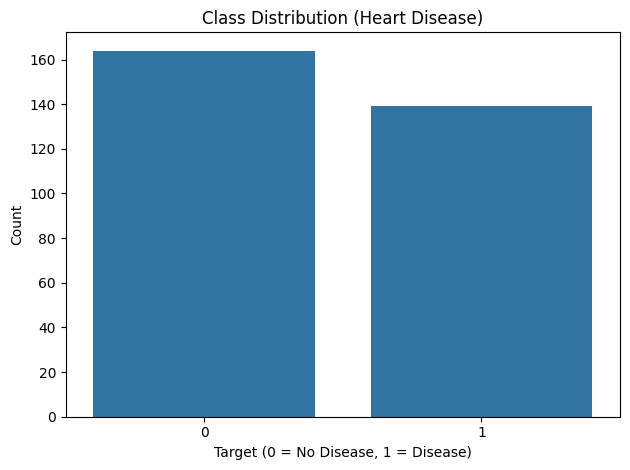

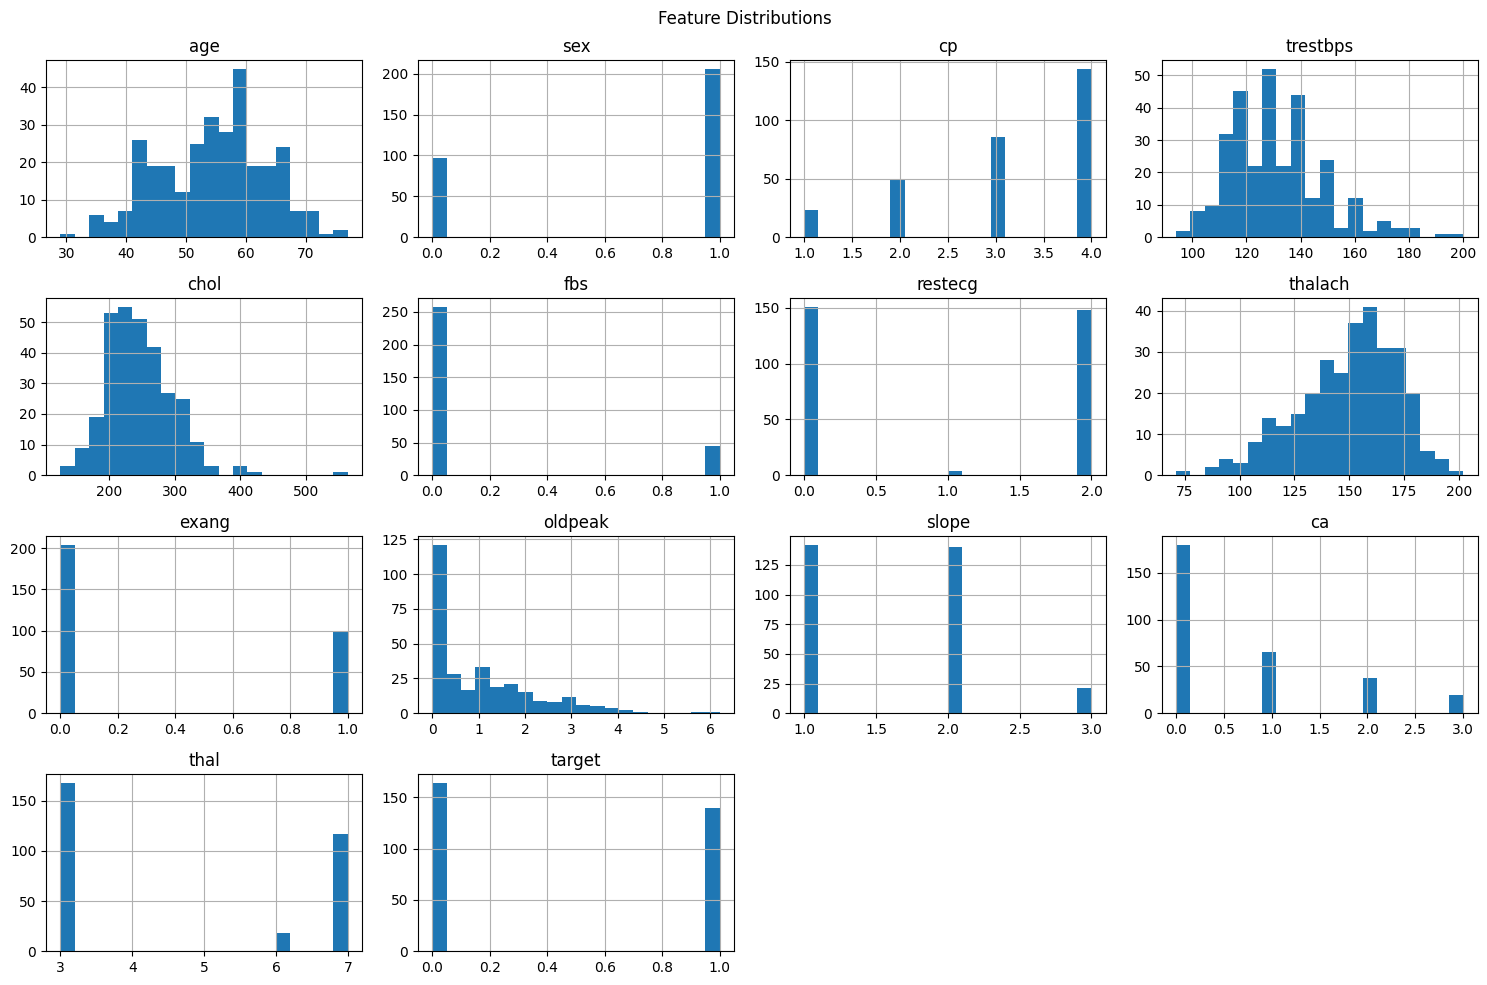

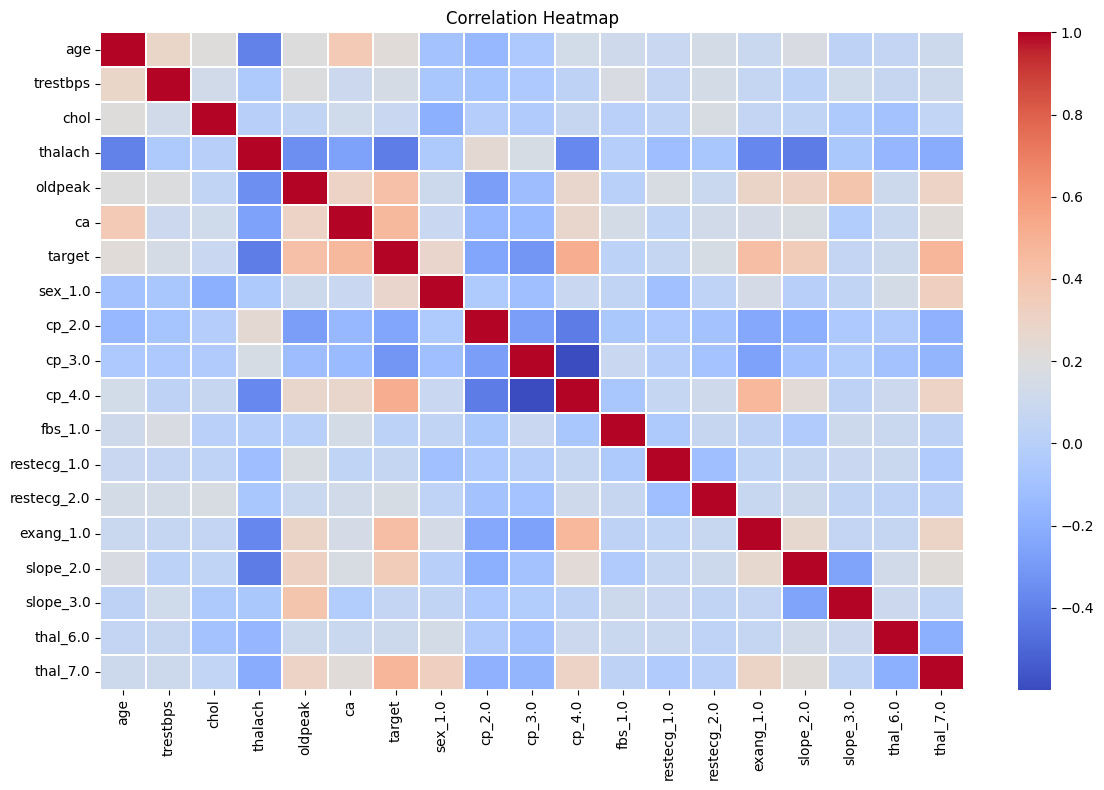

In [13]:
# ==========================================================
# Task 1: Data Acquisition, Preprocessing & EDA (MLflow + UI)
# ==========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from urllib.request import urlretrieve
from sklearn.impute import SimpleImputer

# -------------------------------
# MLflow setup
# -------------------------------
mlflow.set_experiment("HeartDisease-MLflow-MLOps")

with mlflow.start_run(run_name="EDA_and_Preprocessing"):

    
    # 1. Download Dataset
    
    DATA_RAW = "data/raw"
    DATA_PROCESSED = "data/processed"
    os.makedirs(DATA_RAW, exist_ok=True)
    os.makedirs(DATA_PROCESSED, exist_ok=True)

    URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

    COLUMNS = [
        "age", "sex", "cp", "trestbps", "chol",
        "fbs", "restecg", "thalach", "exang",
        "oldpeak", "slope", "ca", "thal", "target"
    ]

    raw_path = os.path.join(DATA_RAW, "heart_disease.csv")
    urlretrieve(URL, raw_path)

    df = pd.read_csv(raw_path, names=COLUMNS)

    mlflow.log_param("data_source", "UCI Heart Disease Cleveland")
    mlflow.log_metric("raw_rows", df.shape[0])
    mlflow.log_metric("raw_columns", df.shape[1])

    
    # 2. Cleaning & Preprocessing
    
    df.replace("?", np.nan, inplace=True)

    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    missing_before = df.isna().sum().sum()

    imputer = SimpleImputer(strategy="median")
    df[df.columns] = imputer.fit_transform(df)

    missing_after = df.isna().sum().sum()

    mlflow.log_metric("missing_values_before", missing_before)
    mlflow.log_metric("missing_values_after", missing_after)

    # Binarize target
    df["target"] = (df["target"] > 0).astype(int)

    # One-hot encode categorical variables
    categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    mlflow.log_metric("processed_rows", df_encoded.shape[0])
    mlflow.log_metric("processed_features", df_encoded.shape[1])

    
    # 3. EDA — SHOW + LOG
    

    # Class balance
    plt.figure()
    sns.countplot(x="target", data=df)
    plt.title("Class Distribution (Heart Disease)")
    plt.xlabel("Target (0 = No Disease, 1 = Disease)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("class_distribution.png")
    plt.show()
    mlflow.log_artifact("class_distribution.png")

    # Feature distributions
    df.hist(figsize=(15, 10), bins=20)
    plt.suptitle("Feature Distributions")
    plt.tight_layout()
    plt.savefig("feature_distributions.png")
    plt.show()
    mlflow.log_artifact("feature_distributions.png")

    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_encoded.corr(), cmap="coolwarm", linewidths=0.3)
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.savefig("correlation_heatmap.png")
    plt.show()
    mlflow.log_artifact("correlation_heatmap.png")

    
    # 4. Save & Track Clean Dataset
    
    clean_path = os.path.join(DATA_PROCESSED, "heart_disease_clean.csv")
    df_encoded.to_csv(clean_path, index=False)
    mlflow.log_artifact(clean_path)



## 2. Feature Engineering & Model Development

In [22]:
# ==========================================================
# Task 2: Feature Engineering & Model Training (MLflow)
# ==========================================================

import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# -------------------------------
# MLflow setup
# -------------------------------
mlflow.set_experiment("HeartDisease-MLflow-MLOps")

# -------------------------------
# Load processed data (from Task 1)
# -------------------------------
DATA_PATH = "data/processed/heart_disease_clean.csv"
df = pd.read_csv(DATA_PATH)

X = df.drop("target", axis=1)
y = df["target"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "roc_auc": "roc_auc"
}

# ==========================================================
# Model 1: Logistic Regression (Scaled)
# ==========================================================
with mlflow.start_run(run_name="LogisticRegression"):

    logreg_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            max_iter=1000,
            solver="liblinear",
            random_state=42
        ))
    ])

    scores = cross_validate(
        logreg_pipeline,
        X, y,
        cv=cv,
        scoring=scoring
    )

    for metric in scoring.keys():
        mlflow.log_metric(f"{metric}_mean", scores[f"test_{metric}"].mean())
        mlflow.log_metric(f"{metric}_std", scores[f"test_{metric}"].std())

    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("cv_folds", 5)

    # Fit final model for registration
    logreg_pipeline.fit(X, y)
    mlflow.sklearn.log_model(logreg_pipeline, "model")

# ==========================================================
# Model 2: Random Forest (No Scaling)
# ==========================================================
with mlflow.start_run(run_name="RandomForest"):

    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1
    )

    scores = cross_validate(
        rf_model,
        X, y,
        cv=cv,
        scoring=scoring
    )

    for metric in scoring.keys():
        mlflow.log_metric(f"{metric}_mean", scores[f"test_{metric}"].mean())
        mlflow.log_metric(f"{metric}_std", scores[f"test_{metric}"].std())

    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("cv_folds", 5)

    # Fit final model for registration
    rf_model.fit(X, y)
    mlflow.sklearn.log_model(rf_model, "model")

print("Task 2 completed: models trained, evaluated, and logged to MLflow.")


2025/12/28 19:55:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/28 19:55:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Task 2 completed: models trained, evaluated, and logged to MLflow.


## Task 3 Experiment Tracking with MLflow ##

Tracking URI: sqlite:///mlflow.db
Experiment set: HeartDisease-MLflow-MLOps

Run ID: ce0aad1ad9374ccab8c392775e017019

Cross-Validation Metrics:
ACCURACY   | Mean: 0.8482 | Std: 0.0302
PRECISION  | Mean: 0.8679 | Std: 0.0506
RECALL     | Mean: 0.7910 | Std: 0.0374
ROC_AUC    | Mean: 0.9111 | Std: 0.0196


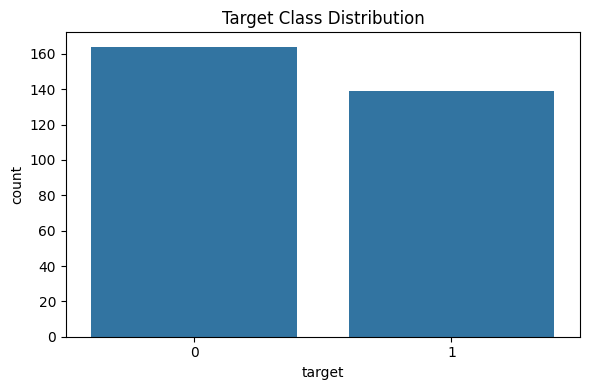

2025/12/28 20:00:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Task 3 completed: params, metrics, artifacts, plots logged AND printed.


In [24]:
# ==========================================================
# Task 3: Experiment Tracking with MLflow
# ==========================================================

import mlflow
import mlflow.sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# -------------------------------
# Hard-pin MLflow (IMPORTANT)
# -------------------------------
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("HeartDisease-MLflow-MLOps")

print("Tracking URI:", mlflow.get_tracking_uri())
print("Experiment set: HeartDisease-MLflow-MLOps")

# -------------------------------
# Load processed data
# -------------------------------
df = pd.read_csv("data/processed/heart_disease_clean.csv")
X = df.drop("target", axis=1)
y = df["target"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "roc_auc": "roc_auc"
}

# ==========================================================
# Tracked Experiment Run
# ==========================================================
with mlflow.start_run(run_name="Experiment_Tracking_Demo") as run:

    print("\nRun ID:", run.info.run_id)

    # Model pipeline
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, solver="liblinear"))
    ])

    # -------------------------------
    # Cross-validation
    # -------------------------------
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)

    metrics = {}
    print("\nCross-Validation Metrics:")
    for m in scoring:
        mean = scores[f"test_{m}"].mean()
        std = scores[f"test_{m}"].std()
        metrics[f"{m}_mean"] = mean
        metrics[f"{m}_std"] = std
        print(f"{m.upper():10s} | Mean: {mean:.4f} | Std: {std:.4f}")

    # Log metrics
    mlflow.log_metrics(metrics)

    # Log parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("cv_folds", 5)

    # -------------------------------
    # Plot & log artifact
    # -------------------------------
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y)
    plt.title("Target Class Distribution")
    plt.tight_layout()
    plt.savefig("task3_class_distribution.png")
    plt.show()

    mlflow.log_artifact("task3_class_distribution.png")

    # -------------------------------
    # Train final model & log
    # -------------------------------
    model.fit(X, y)
    mlflow.sklearn.log_model(model, "model")

print("\nTask 3 completed: params, metrics, artifacts, plots logged AND printed.")


In [26]:
# ==========================================================
# Hyperparameter Experiments: LR + RF (MLflow)
# ==========================================================

import mlflow
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# -------------------------------
# Hard-pin MLflow
# -------------------------------
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("HeartDisease-MLflow-MLOps")

print("Tracking URI:", mlflow.get_tracking_uri())

# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv("data/processed/heart_disease_clean.csv")
X = df.drop("target", axis=1)
y = df["target"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "roc_auc": "roc_auc"
}

# ==========================================================
# Logistic Regression Experiments
# ==========================================================
logreg_params = [
    {"C": 0.1, "penalty": "l2"},
    {"C": 1.0, "penalty": "l2"},
    {"C": 10.0, "penalty": "l2"},
]

print("\n===== Logistic Regression Experiments =====")

for params in logreg_params:
    run_name = f"LR_C{params['C']}"

    with mlflow.start_run(run_name=run_name):
        print(f"\nRun: {run_name}")
        print("Params:", params)

        model = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                C=params["C"],
                penalty=params["penalty"],
                solver="liblinear",
                max_iter=1000
            ))
        ])

        scores = cross_validate(model, X, y, cv=cv, scoring=scoring)

        metrics = {}
        for m in scoring:
            mean = scores[f"test_{m}"].mean()
            std = scores[f"test_{m}"].std()
            metrics[f"{m}_mean"] = mean
            metrics[f"{m}_std"] = std
            print(f"{m.upper():10s} | Mean: {mean:.4f} | Std: {std:.4f}")

        mlflow.log_params(params)
        mlflow.log_param("model_type", "LogisticRegression")
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(model, "model")
# ==========================================================
# Random Forest Experiments
# ==========================================================
rf_params = [
    {"n_estimators": 100, "max_depth": None},
    {"n_estimators": 200, "max_depth": None},
    {"n_estimators": 200, "max_depth": 10},
]

print("\n===== Random Forest Experiments =====")

for params in rf_params:
    run_name = f"RF_ne{params['n_estimators']}_depth{params['max_depth']}"

    with mlflow.start_run(run_name=run_name):
        print(f"\nRun: {run_name}")
        print("Params:", params)

        model = RandomForestClassifier(
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"],
            random_state=42,
            n_jobs=-1
        )

        scores = cross_validate(model, X, y, cv=cv, scoring=scoring)

        metrics = {}
        for m in scoring:
            mean = scores[f"test_{m}"].mean()
            std = scores[f"test_{m}"].std()
            metrics[f"{m}_mean"] = mean
            metrics[f"{m}_std"] = std
            print(f"{m.upper():10s} | Mean: {mean:.4f} | Std: {std:.4f}")

        mlflow.log_params(params)
        mlflow.log_param("model_type", "RandomForest")
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(model, "model")
print("\nAll Logistic Regression and Random Forest experiments completed.")


c:\Users\RGI3\AppData\Local\miniconda3\envs\mlops\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\RGI3\AppData\Local\miniconda3\envs\mlops\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\RGI3\AppData\Local\miniconda3\envs\mlops\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in versi

Tracking URI: sqlite:///mlflow.db

===== Logistic Regression Experiments =====

Run: LR_C0.1
Params: {'C': 0.1, 'penalty': 'l2'}
ACCURACY   | Mean: 0.8417 | Std: 0.0347
PRECISION  | Mean: 0.8516 | Std: 0.0648
RECALL     | Mean: 0.7987 | Std: 0.0277
ROC_AUC    | Mean: 0.9144 | Std: 0.0213


c:\Users\RGI3\AppData\Local\miniconda3\envs\mlops\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\RGI3\AppData\Local\miniconda3\envs\mlops\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\RGI3\AppData\Local\miniconda3\envs\mlops\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in versi


Run: LR_C1.0
Params: {'C': 1.0, 'penalty': 'l2'}
ACCURACY   | Mean: 0.8482 | Std: 0.0302
PRECISION  | Mean: 0.8679 | Std: 0.0506
RECALL     | Mean: 0.7910 | Std: 0.0374
ROC_AUC    | Mean: 0.9111 | Std: 0.0196


c:\Users\RGI3\AppData\Local\miniconda3\envs\mlops\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\RGI3\AppData\Local\miniconda3\envs\mlops\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\RGI3\AppData\Local\miniconda3\envs\mlops\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in versi


Run: LR_C10.0
Params: {'C': 10.0, 'penalty': 'l2'}
ACCURACY   | Mean: 0.8350 | Std: 0.0235
PRECISION  | Mean: 0.8535 | Std: 0.0541
RECALL     | Mean: 0.7767 | Std: 0.0289
ROC_AUC    | Mean: 0.9102 | Std: 0.0177

===== Random Forest Experiments =====

Run: RF_ne100_depthNone
Params: {'n_estimators': 100, 'max_depth': None}


2025/12/28 20:08:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


ACCURACY   | Mean: 0.8349 | Std: 0.0236
PRECISION  | Mean: 0.8556 | Std: 0.0472
RECALL     | Mean: 0.7767 | Std: 0.0624
ROC_AUC    | Mean: 0.9048 | Std: 0.0203

Run: RF_ne200_depthNone
Params: {'n_estimators': 200, 'max_depth': None}


2025/12/28 20:08:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


ACCURACY   | Mean: 0.8317 | Std: 0.0191
PRECISION  | Mean: 0.8496 | Std: 0.0496
RECALL     | Mean: 0.7770 | Std: 0.0524
ROC_AUC    | Mean: 0.9095 | Std: 0.0215

Run: RF_ne200_depth10
Params: {'n_estimators': 200, 'max_depth': 10}


2025/12/28 20:08:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


ACCURACY   | Mean: 0.8284 | Std: 0.0169
PRECISION  | Mean: 0.8478 | Std: 0.0454
RECALL     | Mean: 0.7696 | Std: 0.0543
ROC_AUC    | Mean: 0.9088 | Std: 0.0204

All Logistic Regression and Random Forest experiments completed.


## Task 4 

Multiple models and hyperparameter configurations were evaluated using MLflow-tracked experiments.
Based on cross-validated performance:

Logistic Regression with C = 0.1 was selected as the final model.

This configuration achieved the highest recall with low variance, which is critical for heart disease risk prediction where minimizing false negatives is important.

Logistic Regression also offers interpretability, making it suitable for medical decision-support systems.

In [27]:
# ==========================================================
# Task 4: Model Packaging & Reproducibility
# ==========================================================

import mlflow
import mlflow.sklearn
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# -------------------------------
# Pin MLflow tracking (important)
# -------------------------------
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("HeartDisease-MLflow-MLOps")

print("Tracking URI:", mlflow.get_tracking_uri())

# -------------------------------
# Load processed dataset
# -------------------------------
df = pd.read_csv("data/processed/heart_disease_clean.csv")
X = df.drop("target", axis=1)
y = df["target"]

# -------------------------------
# Final preprocessing + model
# -------------------------------
final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        C=0.1,
        penalty="l2",
        solver="liblinear",
        max_iter=1000
    ))
])

# -------------------------------
# Train and package model
# -------------------------------
with mlflow.start_run(run_name="Final_Model_LR_C0.1") as run:
    print("Run ID:", run.info.run_id)

    final_pipeline.fit(X, y)

    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("C", 0.1)
    mlflow.log_param("scaling", "StandardScaler")

    mlflow.sklearn.log_model(
        sk_model=final_pipeline,
        artifact_path="model",
        registered_model_name="HeartDiseaseClassifier"
    )

print("\nFinal model packaged and registered successfully.")


c:\Users\RGI3\AppData\Local\miniconda3\envs\mlops\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
2025/12/28 20:20:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Tracking URI: sqlite:///mlflow.db
Run ID: 1c9f877c5ba64f6784daf4f706c7b5b5


2025/12/28 20:20:36 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/28 20:20:36 INFO mlflow.store.db.utils: Updating database tables
2025/12/28 20:20:36 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/28 20:20:36 INFO alembic.runtime.migration: Will assume non-transactional DDL.



Final model packaged and registered successfully.


Successfully registered model 'HeartDiseaseClassifier'.
Created version '1' of model 'HeartDiseaseClassifier'.


### Reproducibility Verification

In [28]:
# ==========================================================
# Re-load model and run inference (Reproducibility check)
# ==========================================================

import mlflow.pyfunc

model_uri = "models:/HeartDiseaseClassifier/None"
model = mlflow.pyfunc.load_model(model_uri)

sample_input = X.iloc[:5]
predictions = model.predict(sample_input)

print("Sample predictions:", predictions)


Sample predictions: [0 1 1 0 0]
